# Scikit-Learn Permutation Importance with Categorical Features

Suppose you have a categorical variable with many unique entries. One-hot encoding breaks up categorical features into new, binary features. However, for certain analyses such as permutation importance, it is often desirable to look at the importance of the original categorical feature rather than the newly created binary features.

In this notebook, we are looking at an example to see how we can deal with categorical features in a permutation importance context.

In particular, we will see that pandas DataFrames and scikit-learn's [make_column_selector](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html) are a nice combo that allows us to analyze categorical features just the way we want -- without breaking it up into individual one-hot encoded variables.

## Dataset

Suppose we have the following dataset with 2 numerical features and 1 categorical features:

In [1]:
import pandas as pd
import numpy as np


d = {'feat1': np.arange(5.), 
     'feat2': np.arange(5., 10.), 
     'feat3': ['A', 'B', 'B', 'C', 'A']}

y_train = np.arange(5)
X_train = pd.DataFrame(d)
X_train['feat3'] = X_train['feat3'].astype('category')


X_train

,feat1,feat2,feat3
0,0.0,5.0,A
1,1.0,6.0,B
2,2.0,7.0,B
3,3.0,8.0,C
4,4.0,9.0,A


Let's use pandas' new `category` type for the categorical features. In the next section, you will see why ;).

In [2]:
X_train.dtypes

feat1     float64
feat2     float64
feat3    category
dtype: object

Also, let's create a test set partition for the permutation analysis later:

In [3]:
d2 = {'feat1': np.arange(4.), 
      'feat2': np.arange(4., 8.), 
      'feat3': ['A', 'B', 'B', 'C']}

y_test = np.arange(4)
X_test = pd.DataFrame(d2)
X_test['feat3'] = X_test['feat3'].astype('category')


X_test

,feat1,feat2,feat3
0,0.0,4.0,A
1,1.0,5.0,B
2,2.0,6.0,B
3,3.0,7.0,C


## Independent One-Hot Encoded Features

In this section, we are looking at the standard approach at first, where the categorical feature gets broken into several binary features.



First, we define a data transformer that scales the numerical features (a standard procedure recommended for most ML algorithms) and one-hot encode the categorical feature:

In [9]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler


ct = make_column_transformer(
       (StandardScaler(), # scale numerical data
        make_column_selector(dtype_include=np.number)),
       (OneHotEncoder(), # one-hot encode categorical data
        make_column_selector(dtype_include="category")))

X_train_t = ct.fit_transform(X_train)
X_test_t = ct.transform(X_test)

Looking at the code above, that's where pandas DataFrames come in handy. Using the `make_column_selector` with specific column types, we can choose which features we pass to which preprocessor. Neat!

(Note that NumPy arrays don't support mixed types, so the column transformer approach above would not work with NumPy arrays.)

Next, let's fit out predictive model based on the transformed data:

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model.fit(X_train_t, y_train);

Finally, let's compute the feature importance and visualize it in a bar plot:

In [11]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test_t, y_test,
                           n_repeats=200,
                           random_state=0)

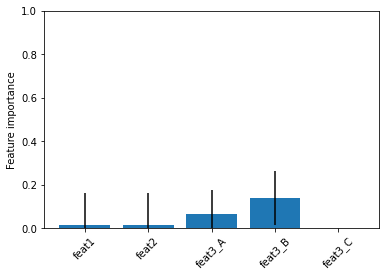

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(r['importances_mean'].shape[0]), r['importances_mean'],
        yerr=r['importances_std'], align="center")

plt.ylabel('Feature importance')

plt.xticks(range(5),
           ['feat1', 'feat2', 'feat3_A', 'feat3_B', 'feat3_C'], rotation=45)

plt.ylim([0, 1.])
plt.show()

As we can see above, each categorical feature is its own variable. However, for several real-world problems (let's say you have a biological dataset and want to know how important it is to include information about the amino acid type -- a categorical variable with 20 unique values), it would be more useful to know the overall importance of the categorical feature. Let's look at this in the next section.

## Grouped One-hot Encoded Features

instead of breaking up the categorical feature into individual binary features prior to the permutation importance analysis, let's see how we can analyze the categorical feature as a whole.

Here, all we have to do is to combine our column transformer and predictive model into a pipeline and use that pipeline in the `permutation_importance` function and pass it the untransformed test set:

In [19]:
from sklearn.pipeline import make_pipeline 

model_pipe = make_pipeline(ct, model)

r = permutation_importance(model_pipe, X_test, y_test,
                           n_repeats=200,
                           random_state=0)

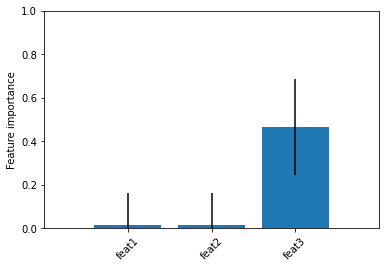

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(r['importances_mean'].shape[0]), r['importances_mean'],
        yerr=r['importances_std'], align="center")

plt.xticks(range(len(X_train.columns)),
           np.array(X_train.columns), rotation=45)
plt.ylabel('Feature importance')

plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 1.])
plt.show()

As we can see, the categorical feature is now treated as a single feature.

So, what happened and how did this work? The permutation importance function permutes features before passing it to the `model_pipe`. So, the `model_pipe` performs the one-hot encoding after we permuted it rather then before.